In [1]:
"""
Identify wildfire events with >= 1% pre-fire aspen forest cover across western U.S. ecoregions
Landcover data: LANDFIRE Existing Vegetation Type (EVT) ca. 2016
Author: maxwell.cook@colorado.edu
"""

import os, time, glob, gc
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
import dask

from shapely.geometry import box
from shapely.geometry import Polygon, MultiPolygon
from datetime import datetime
from rasterstats import zonal_stats

import warnings
warnings.filterwarnings("ignore") # suppresses annoying geopandas warning

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

# maindir = '/home/jovyan/' # cyverse
# projdir = os.path.join(maindir,'data-store/data/iplant/home/maco4303/data/JFSP')

print("Ready to go !")

Ready to go !


In [2]:
results_dir = os.path.join(projdir,'data/tabular/mod/EVT/')
# results_dir = os.path.join(projdir,'results/') # cyverse
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(f"Saving EVT summary tables to {results_dir}")

Saving EVT summary tables to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/EVT/


In [3]:
def compute_band_stats(geoms, image_da, id_col):
    """
    Function to compute band statistics for a chunk of geometries and a raster band.
    This function is passed to the multiprocessing workers.
    """
    affine = image_da.rio.transform()
    nodataval = image_da.rio.nodata
    arr = image_da.values
    
    stats = zonal_stats(
        vectors=geoms[[id_col, 'geometry']],
        raster=arr,
        affine=affine,
        nodata=nodataval,
        categorical=True,
        all_touched=True,
        geojson_out=True
    )

    # Extract the results (properties)
    stats_df = pd.DataFrame(stats)
    stats_df[id_col] = stats_df['properties'].apply(lambda x: x.get(id_col))
    stats_df['properties'] = stats_df['properties'].apply(lambda x: {key: val for key, val in x.items() if key != id_col})
    stats_df['props_list'] = stats_df['properties'].apply(lambda x: list(x.items()))

    # Explode the properties to column
    props = stats_df.explode('props_list').reset_index(drop=True)
    props[['evt', 'count']] = pd.DataFrame(props['props_list'].tolist(), index=props.index)
    props['evt'] = props['evt'].astype(int)
    props = props[[id_col, 'evt', 'count']].reset_index(drop=True)

    # Calculate the total pixels and percent cover
    total_pixels = props.groupby(props[id_col])['count'].transform('sum')
    props['total_pixels'] = total_pixels
    props['pct_cover'] = (props['count'] / props['total_pixels']) * 100

    del arr, stats, stats_df # clean up
    gc.collect()
    
    return props


def create_bounds(gdf, buffer=None):
    """ Calculate a bounding rectangle for a given geometry and buffer """
    bounds = gdf.geometry.apply(lambda geom: box(*geom.bounds))
    if buffer is not None:
        bounds = bounds.buffer(buffer)
    # Assign the geometry to the geodataframe
    gdf_ = gdf.copy()
    gdf_.geometry = bounds.geometry.apply(
        lambda geom: Polygon(geom) if geom.geom_type == 'Polygon' else MultiPolygon([geom])
    )
    return gdf_
    

print("Functions loaded !")

Functions loaded !


In [4]:
# """
# Copy the data-store to 'local' directory
# This enables quick access to data files in CyVerse
# """
# import shutil

# # Set a destination path (this is a 'local' and temporary path)
# dest = '/home/jovyan/data-store/aspen-fire/data' 
# if not os.path.exists(dest):
#     os.mkdir(dest) # create the directory for the copied data, if needed
    
# # Using 'shutil' package, copy all the files over
# shutil.copytree(projdir, dest, dirs_exist_ok=True)

In [5]:
# Load the land cover data

In [6]:
# Load the LANDFIRE EVT (ca. 2016)
evt_fp = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')
# evt_fp = os.path.join(dest,'LC16_EVT_200.tif') # cyverse

evt_da = rxr.open_rasterio(evt_fp, masked=True, cache=False, chunks='auto').squeeze()

shp, gt, wkt, nd = evt_da.shape, evt_da.spatial_ref.GeoTransform, evt_da.rio.crs, evt_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {evt_da[0].dtype}")
gc.collect()

Shape: (97283, 154207); 
GeoTransform: -2362425.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


60

In [7]:
# Load FIRED perimeters

In [8]:
# Load the FIRED perimeters (2012-2023)
daily_fp = os.path.join(maindir,'aspen-fire/Aim2/data/spatial/raw/FIRED/fired-daily_west_2012_to_2023.gpkg')
# daily_fp = os.path.join(dest,'fired-daily_west_2012_to_2023.gpkg') # cyverse
daily = gpd.read_file(daily_fp)
daily = daily[daily['ig_year'] >= 2018] # Work with 2018-> (for Sentinel)
daily = daily.to_crs(proj) # ensure albers projection
daily.columns

Index(['did', 'id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
       'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
       'mx_grw_px', 'mx_grw_km2', 'mx_grw_dte', 'ig_utm_x', 'ig_utm_y',
       'na_l3name', 'geometry'],
      dtype='object')

In [9]:
# Add a one pixel buffer to the daily perimeters ()
n_pixels = 500  # meters
daily_ = daily.copy() # make a copy of the original data
daily_['geometry'] = daily_['geometry'].buffer(n_pixels)
print(f"Buffered by {n_pixels/500} pixel(s).")

Buffered by 1.0 pixel(s).


In [10]:
# Crop the image data to the fire bounds

In [11]:
# Crop the raster by the fire bounds (with small buffer)
bounds = daily_.total_bounds
evt_da_crop = evt_da.rio.clip_box(
    minx=bounds[0]+1000, 
    miny=bounds[1]+1000, 
    maxx=bounds[2]+1000, 
    maxy=bounds[3]+1000
)
del evt_da, bounds
gc.collect()

66

In [12]:
# Calculate the daily land cover (EVT) proportions for daily perimeters

In [13]:
t0 = time.time()

sampled = compute_band_stats(daily_, evt_da_crop, 'did')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 1.82 minutes.

~~~~~~~~~~



In [14]:
sampled.head()

,did,evt,count,total_pixels,pct_cover
0,0003d89c00208d55887fec4a95f58ac8,7017,2,5026,0.039793
1,0003d89c00208d55887fec4a95f58ac8,7080,4,5026,0.079586
2,0003d89c00208d55887fec4a95f58ac8,7123,5,5026,0.099483
3,0003d89c00208d55887fec4a95f58ac8,7127,5,5026,0.099483
4,0003d89c00208d55887fec4a95f58ac8,7296,36,5026,0.716275


In [15]:
gc.collect() # clear any unused memory

0

In [16]:
# Load the lookup info to get landcover type

In [17]:
lookup_fp = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
# lookup = os.path.join(dest, 'LF16_EVT_200.csv') # cyverse
lookup = pd.read_csv(lookup_fp)
lookup.columns

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')

In [18]:
# Subset the codes we want to join, join back to the dataframe
lookup = lookup[['VALUE','EVT_NAME','EVT_PHYS','EVT_GP_N','EVT_CLASS']]
# Merge back to the data
props_df = sampled.merge(lookup, left_on='evt', right_on='VALUE', how='left')
props_df.head()

,did,evt,count,total_pixels,pct_cover,VALUE,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS
0,0003d89c00208d55887fec4a95f58ac8,7017,2,5026,0.039793,7017,Columbia Plateau Western Juniper Woodland and ...,Conifer,Juniper Woodland and Savanna,Open tree canopy
1,0003d89c00208d55887fec4a95f58ac8,7080,4,5026,0.079586,7080,Inter-Mountain Basins Big Sagebrush Shrubland,Shrubland,Big Sagebrush Shrubland and Steppe,Shrubland
2,0003d89c00208d55887fec4a95f58ac8,7123,5,5026,0.099483,7123,Columbia Plateau Steppe and Grassland,Grassland,Grassland and Steppe,Herbaceous-shrub-steppe
3,0003d89c00208d55887fec4a95f58ac8,7127,5,5026,0.099483,7127,Inter-Mountain Basins Semi-Desert Shrub-Steppe,Shrubland,Desert Scrub,Shrubland
4,0003d89c00208d55887fec4a95f58ac8,7296,36,5026,0.716275,7296,Developed-Low Intensity,Developed-Low Intensity,Developed-Low Intensity,No Dominant Lifeform


In [19]:
# retrieve the FIRED_ID from the original dataframe
props_df = props_df.merge(daily[['id','did']], left_on='did', right_on='did', how='left')
print(f"There are [{len(props_df['id'].unique())}] unique fires in the sampled data.\n\t[{len(props_df['did'].unique())}] individual daily perimeters.")

There are [10430] unique fires in the sampled data.
	[36790] individual daily perimeters.


In [20]:
props_df.columns

Index(['did', 'evt', 'count', 'total_pixels', 'pct_cover', 'VALUE', 'EVT_NAME',
       'EVT_PHYS', 'EVT_GP_N', 'EVT_CLASS', 'id'],
      dtype='object')

In [21]:
props_df = props_df[['id', 'did', 'evt', 'count', 'total_pixels', 'pct_cover', 
                     'EVT_NAME', 'EVT_PHYS', 'EVT_GP_N', 'EVT_CLASS']]

In [22]:
# Save the file out.
out_fp = os.path.join(results_dir, 'fired-daily_west_2018_to_2023-EVT.csv')
props_df.to_csv(out_fp)
print(f"Saved to {out_fp}")

Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/EVT/fired-daily_west_2018_to_2023-EVT.csv


In [23]:
del sampled, props_df, daily
gc.collect()

0

In [24]:
# Calculate event-level EVT proportions

In [25]:
# Load the FIRED perimeters (2012-2023)
events_fp = os.path.join(projdir,'data/spatial/raw/FIRED/fired-events_west_2012_to_2023.gpkg')
# events_fp = os.path.join(dest, 'fired-events_west_2012_to_2023.gpkg') # cyverse
events = gpd.read_file(events_fp)
events = events[events['ig_year'] >= 2018] # Work with 2018-> (for Sentinel)
events = events.to_crs(proj) # ensure albers projection
events.columns

Index(['id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
       'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
       'mx_grw_px', 'mx_grw_km2', 'mx_grw_dte', 'ig_utm_x', 'ig_utm_y',
       'na_l3name', 'geometry'],
      dtype='object')

In [26]:
# Add a one pixel buffer to the daily perimeters ()
n_pixels = 500  # meters
events_ = events.copy() # make a copy of the original data
events_['geometry'] = events_['geometry'].buffer(n_pixels)
print(f"Buffered by {n_pixels/500} pixel(s).")

Buffered by 1.0 pixel(s).


In [27]:
t0 = time.time()

sampled = compute_band_stats(events_, evt_da_crop, 'id')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 1.07 minutes.

~~~~~~~~~~



In [28]:
props_df = sampled.merge(lookup, left_on='evt', right_on='VALUE', how='left')
props_df.head()

,id,evt,count,total_pixels,pct_cover,VALUE,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS
0,10,7035,14,2678,0.522778,7035,North Pacific Dry Douglas-fir-(Madrone) Forest...,Conifer,Douglas-fir Forest and Woodland,Closed tree canopy
1,10,7037,1263,2678,47.162061,7037,North Pacific Maritime Dry-Mesic Douglas-fir-W...,Conifer,Douglas-fir-Western Hemlock Forest and Woodland,Closed tree canopy
2,10,7039,690,2678,25.765497,7039,North Pacific Maritime Mesic-Wet Douglas-fir-W...,Conifer,Douglas-fir-Western Hemlock Forest and Woodland,Closed tree canopy
3,10,7043,562,2678,20.985810,7043,Mediterranean California Mixed Evergreen Forest,Conifer,California Mixed Evergreen Forest and Woodland,Closed tree canopy
4,10,7063,36,2678,1.344287,7063,North Pacific Broadleaf Landslide Forest,Hardwood,Red Alder Forest and Woodland,Closed tree canopy


In [29]:
props_df.columns

Index(['id', 'evt', 'count', 'total_pixels', 'pct_cover', 'VALUE', 'EVT_NAME',
       'EVT_PHYS', 'EVT_GP_N', 'EVT_CLASS'],
      dtype='object')

In [30]:
props_df = props_df[['id', 'evt', 'count', 'total_pixels', 'pct_cover', 
                     'EVT_NAME', 'EVT_PHYS', 'EVT_GP_N', 'EVT_CLASS']]

In [31]:
# Save the files out.
out_fp = os.path.join(results_dir, 'fired-events_west_2018_to_2023-EVT.csv')
props_df.to_csv(out_fp)
print(f"Saved to {out_fp}")

Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/EVT/fired-events_west_2018_to_2023-EVT.csv


In [32]:
del sampled, props_df # clean up
gc.collect()

0

In [33]:
# Compare with a more broad scale approach (event summary within 3km bounds)

In [36]:
# Create new geometry (bounds) with 1km buffer
bounds = create_bounds(events, buffer=3000)
bounds = bounds[['id','geometry']] # keep it simple
bounds = bounds.set_crs(proj, allow_override=True) # ensure correct crs
out_fp = os.path.join(projdir,'data/spatial/mod/FIRED/fired-events_west_2018_to_2023.gpkg')
bounds.to_file(out_fp)
print(f"Saved bounds to {out_fp}")

Saved bounds to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/FIRED/fired-events_west_2018_to_2023.gpkg


In [37]:
t0 = time.time()

sampled = compute_band_stats(bounds, evt_da_crop, 'id')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 1.49 minutes.

~~~~~~~~~~



In [38]:
sampled.head()

,id,evt,count,total_pixels,pct_cover
0,10,7008,21,44300,0.047404
1,10,7035,710,44300,1.602709
2,10,7037,20936,44300,47.259594
3,10,7039,12813,44300,28.923251
4,10,7043,7282,44300,16.437923


In [39]:
props_df_3k = sampled.merge(lookup, left_on='evt', right_on='VALUE', how='left')
props_df_3k.head()

,id,evt,count,total_pixels,pct_cover,VALUE,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS
0,10,7008,21,44300,0.047404,7008,North Pacific Oak Woodland,Hardwood,Western Oak Woodland and Savanna,Open tree canopy
1,10,7035,710,44300,1.602709,7035,North Pacific Dry Douglas-fir-(Madrone) Forest...,Conifer,Douglas-fir Forest and Woodland,Closed tree canopy
2,10,7037,20936,44300,47.259594,7037,North Pacific Maritime Dry-Mesic Douglas-fir-W...,Conifer,Douglas-fir-Western Hemlock Forest and Woodland,Closed tree canopy
3,10,7039,12813,44300,28.923251,7039,North Pacific Maritime Mesic-Wet Douglas-fir-W...,Conifer,Douglas-fir-Western Hemlock Forest and Woodland,Closed tree canopy
4,10,7043,7282,44300,16.437923,7043,Mediterranean California Mixed Evergreen Forest,Conifer,California Mixed Evergreen Forest and Woodland,Closed tree canopy


In [40]:
# Save the file.
out_fp = os.path.join(results_dir, 'fired-events_west_2012_to_2023-EVT-3km.csv')
props_df_3k.to_csv(out_fp)
print(f"Saved to {out_fp}")

Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/EVT/fired-events_west_2012_to_2023-EVT-3km.csv


In [41]:
del lookup, sampled, props_df_3k
gc.collect()

0

In [ ]:
# Make some plots!

In [45]:
event_evt_fp = os.path.join(results_dir, 'fired-events_west_2018_to_2023-EVT.csv')
event_evt = pd.read_csv(event_evt_fp)
event_evt.columns

Index(['Unnamed: 0', 'id', 'evt', 'count', 'total_pixels', 'pct_cover',
       'EVT_NAME', 'EVT_PHYS', 'EVT_GP_N', 'EVT_CLASS'],
      dtype='object')

In [46]:
cols = ['id', 'evt', 'count', 'total_pixels', 'pct_cover',
        'EVT_NAME', 'EVT_PHYS', 'EVT_GP_N', 'EVT_CLASS']
event_evt = event_evt[cols]
event_evt = pd.merge(events, event_evt, left_on='id', right_on='id', how='right')
event_evt.head()

,id,ig_date,ig_day,ig_month,ig_year,last_date,event_dur,tot_pix,tot_ar_km2,fsr_px_dy,...,na_l3name,geometry,evt,count,total_pixels,pct_cover,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS
0,10,2018-10-22,295,10,2018,2018-10-22,1,1,0.214659,1.0,...,Coast Range,"MULTIPOLYGON (((-2203843.968 2576124.568, -220...",7035,14,2678,0.522778,North Pacific Dry Douglas-fir-(Madrone) Forest...,Conifer,Douglas-fir Forest and Woodland,Closed tree canopy
1,10,2018-10-22,295,10,2018,2018-10-22,1,1,0.214659,1.0,...,Coast Range,"MULTIPOLYGON (((-2203843.968 2576124.568, -220...",7037,1263,2678,47.162061,North Pacific Maritime Dry-Mesic Douglas-fir-W...,Conifer,Douglas-fir-Western Hemlock Forest and Woodland,Closed tree canopy
2,10,2018-10-22,295,10,2018,2018-10-22,1,1,0.214659,1.0,...,Coast Range,"MULTIPOLYGON (((-2203843.968 2576124.568, -220...",7039,690,2678,25.765497,North Pacific Maritime Mesic-Wet Douglas-fir-W...,Conifer,Douglas-fir-Western Hemlock Forest and Woodland,Closed tree canopy
3,10,2018-10-22,295,10,2018,2018-10-22,1,1,0.214659,1.0,...,Coast Range,"MULTIPOLYGON (((-2203843.968 2576124.568, -220...",7043,562,2678,20.985810,Mediterranean California Mixed Evergreen Forest,Conifer,California Mixed Evergreen Forest and Woodland,Closed tree canopy
4,10,2018-10-22,295,10,2018,2018-10-22,1,1,0.214659,1.0,...,Coast Range,"MULTIPOLYGON (((-2203843.968 2576124.568, -220...",7063,36,2678,1.344287,North Pacific Broadleaf Landslide Forest,Hardwood,Red Alder Forest and Woodland,Closed tree canopy


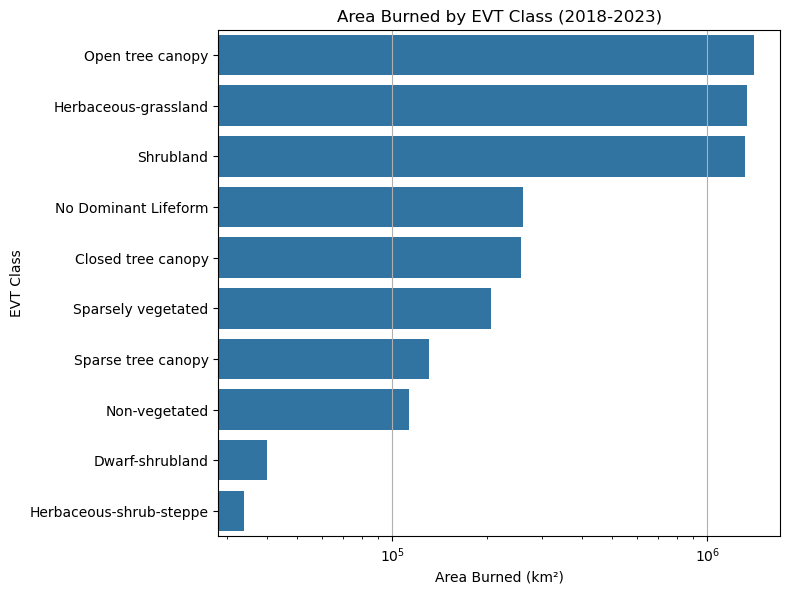

In [53]:
# Aggregate total burned area by ecoregion
lc_burned_area = event_evt.groupby('EVT_CLASS')['tot_ar_km2'].sum().reset_index()
# Sort the data by total burned area in descending order
lc_burned_area = lc_burned_area.sort_values(by='tot_ar_km2', ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='tot_ar_km2', y='EVT_CLASS', data=lc_burned_area)
plt.title('Area Burned by EVT Class (2018-2023)', fontsize=12)
plt.xlabel('Area Burned (km²)', fontsize=10)
plt.ylabel('EVT Class', fontsize=10)
plt.grid(True, axis='x')
plt.tight_layout()

plt.xscale('log')

# Show the plot
plt.show()